<a href="https://colab.research.google.com/github/chumpblocckami/AmazonTextClustering/blob/master/TextMiningV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **AMAZON REVIEW DATASET**
Amazon review dataset is a collection of reviews per categories. Each dataset is very large because it spans over years from May 1996 to 2008. Inside we can find some features for the objects like the review, the overrall score, the key af all the products etc.

We have also the dataset of the metadata, that contains other features related to the single product, like its sub-category, other products related to it, the price and so on.

The total dataset contains 20 milions reviwes, so we have decided to take the reduced one, that contains just 6 milions, and to take a sample of it for our analysis.


# **GOALS**

We have tried to give an answer to two questions:
1. **Can we classify an object according to its review?**
2. **Which are the most important reviews in the dataset?**
3. **Is there a way to cluster reviews based on what did go wrong?**

# **INDEX**

0. Explorative analysis:
  - Merge of the dataset with metadata
  - Columns removal
  - Sampling
1. Preprocessing:
  - Normalization
  - Stop words removal
  - Lemmatization
  - English Words
  - Stemming
  - OVERVIEW
2. Classification:
    - TF-IDF
      - RandomForest
      - KneighborsClassifier
      - Linear SVC
      - Multinomial NB
    - DOC2VEC
      - RandomForest
      - KneighborsClassifier
      - Linear SVC
      - Multinomial NB
  - OVERVIEW

3. Text Summarization
  - Similarity Matrix
  - PageRank Score
4. Clustering
  - Preprocessing
  - PageRank score
  - Vocaboulary check
  - Get centroids and clusters
5. Conclusions



# 0.0 EXPLORATIVE ANALYSIS

In this section we'll get the data from the repository, load in a appropiate file and we'll get the samples that we're going to use for classification, summarization and cluster.



In [0]:
link = "http://jmcauley.ucsd.edu/data/amazon/"
!wget "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Electronics_5.json.gz"
!wget "http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Electronics.json.gz"

--2019-12-13 13:34:24--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Electronics.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 714715395 (682M) [application/octet-stream]
Saving to: ‘meta_Electronics.json.gz’

meta_Electronics.js 100%[===================>] 681.61M  10.1MB/s    in 68s     

2019-12-13 13:35:32 (10.1 MB/s) - ‘meta_Electronics.json.gz’ saved [714715395/714715395]



In [0]:
#Load the dataset
#IN: file .json.gz
#OUT: pandas dataframe
import pandas as pdimport gzip
import json 
import time 

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [0]:
time1 = time.time()
df = getDF("Electronics_5.json.gz")
print(f"Time dedicated to loading data: {(time.time()-time1)/60:.2f}")
df.head()

In [0]:
time1 = time.time()
meta = getDF("meta_Electronics.json.gz")
print(f"Time dedicated to loading meta-data: {(time.time()-time1)/60:.2f}")
meta.head()

In [0]:
#MERGE METADATA AND DATA
df = data
meta = meta.loc[meta.astype(str).drop_duplicates().index]
merged = df.merge(meta, on="asin",how="inner")
data = merged

In [0]:
#CUT NAN'S VALUE
data = data.loc[data["verified"]==True]
print(f"% nans values in reviews:",data.loc[pd.isna(data["reviewText"])].shape[0] / data.shape[0] * 100,"%")
data = data.loc[pd.isna(data["reviewText"])==False]

#SAMPLE THE DATA (10K FOR EACH MOST POPULATED CATEGORY IN THE DATASET)
random_state = 420
n = 10_000
a =data.loc[data["main_cat"] == "Computers"].sample(n = n, random_state = random_state)
b =data.loc[data["main_cat"] == "Camera & Photo"].sample(n = n, random_state = random_state)
c =data.loc[data["main_cat"] == "Automotive"].sample(n = n, random_state = random_state)
d =data.loc[data["main_cat"] == "Sports & Outdoors"].sample(n = n, random_state = random_state)
e =data.loc[data["main_cat"] == "Musical Instruments"].sample(n = n, random_state = random_state)
f =data.loc[data["main_cat"] == "Health & Personal Care"].sample(n = n, random_state = random_state)
g =data.loc[data["main_cat"] == "Video Games"].sample(n = n, random_state = random_state)
h =data.loc[data["main_cat"] == "Home Audio & Theater"].sample(n = n, random_state = random_state)

list = [a,b,c,d,e,f,g,h]
sdata = pd.concat(list)

sdata = sdata.drop(columns="vote verified reviewTime reviewerID asin style reviewerName unixReviewTime image_x description title image_y brand feature rank date price also_buy also_view similar_item tech1 tech2 details fit category".split(" "))

from sklearn.utils import shuffle
sdata = sdata.sample(frac = 1)

#SE LASCIATI DENTRO I UNNAMED, ALLORA FAR GIRARE LA RIGA SOTTO
sdata = sdata.drop(columns = ["Unnamed: 0_x","Unnamed: 0_y"])

Percentuale di dati nulli: 0.02109870251260043 %


In [0]:
#EXPORT DATASETS
#DATASET WITH REVIEWS
df.to_csv("drive/My Drive/TextMining/RawDataset.csv")
#METADATA DATASET
meta.to_csv("drive/My Drive/TextMining/MetaDataset.csv")
#MERGED DATASET
merged.to_csv("drive/My Drive/TextMining/RawDatasetMerged.csv")
#SAMPLED DATASET
sdata.to_csv("drive/My Drive/TextMining/SampleDataset.csv")

# 1.0 PREPROCESSING


In this section we'll introduce and we'll apply every techniques that are able to 'clean' the text, in order to remove noise and discretize semantic.

In [0]:
# REIMPORTIAMO
data = pd.read_csv("drive/My Drive/images/TextMining/SampleDataset.csv")

## 1.1 Normalization

Normalization is used to generalize the text, in order to have all the words in the same form. 
In this section we're going to get all the words in lowercase, translate contraptions, remove puntuaction and check typos or elementary grammar errors.

In [0]:
#IN: string
#OUT: string in lowercase, without puntuactions and numbers.

import string
import re
import contextlib
!pip install autocorrect
import autocorrect
from autocorrect import spell 
import pandas as pd 
import nltk
nltk.download('words')
nltk.download("punkt")

#carico le contraptions (es. don't -> do not)
f = open("drive/My Drive/images/TextMining/contraptions.txt")
contraptions = {}
for line in f.readlines():
  keys,values = line.replace("\n","").split(": ")
  contraptions[keys] = values

def getNormalized(strings):
    text = strings.translate(str.maketrans('','',string.punctuation.replace("'","")))
    if True:
      text = text.split()
      new_text = []
      for word in text:
          if word in contraptions:
              new_text.append(contraptions[word])
          else:
              new_text.append(word)
    text = " ".join(new_text)
    processed = " ".join(nltk.word_tokenize(re.sub('[^A-Za-z0-9]+', ' ', str.lower(text))))
    processed1 = processed.translate(str.maketrans('','',string.punctuation)).translate(str.maketrans('','','1234567890')).strip()
    output = nltk.word_tokenize(processed1)
    return " ".join(output)

  
data["reviewTextNormalized"] = data.apply(lambda row:getNormalized(row["reviewText"]),axis=1)

#correcting typos and other grammar mistake
with contextlib.redirect_stdout(None):
    data["reviewTextTNormalized"] = [' '.join([spell(i) for i in x.split()]) for x in data['reviewTextNormalized']]

     |████████████████████████████████| 19.1MB 150kB/s 
  Created wheel for autocorrect: filename=autocorrect-0.4.4-cp36-none-any.whl size=19134813 sha256=040955d3ef9168b163735e666691ad5d9136bf975e447c5d9666abf56700e6f9
  Stored in directory: /root/.cache/pip/wheels/e5/80/6d/feed99c22f3f15b0b6881569dc9021f7e94b6464aa0688d819
Successfully built autocorrect
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [1]:
data.head()

NameError: ignored

## 1.2 Stop words removal

Stopwords are words that are very frequent in the documents but aren't very informative, such as articles or conjuctions. 
The main point of stop words removal is to delete all this non-informative words. 

In [0]:
#IN: normalized string
#OUT: string without stopwords (stopwords are words so frequent in a corpus that are not valuable (the, and, to...))
#Before applying this methods, see the distribution of the words in the text.

import nltk
nltk.download("punkt")
from collections import Counter
import pprint

tutto = []
tutto = " ".join(data["reviewTextNormalized"].tolist())
tutto = nltk.word_tokenize(tutto)
pprint.pprint(Counter(tutto).most_common(10))
pd.DataFrame(Counter(tutto).most_common(100)).plot();

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[('not', 59324),
 ('great', 24600),
 ('good', 18654),
 ('one', 17885),
 ('use', 16192),
 ('works', 15827),
 ('would', 15166),
 ('well', 13998),
 ('like', 13431),
 ('get', 11311)]


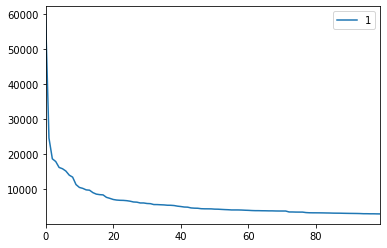

In [0]:
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
stopwords_ = set(stopwords.words('english'))
stopwords_.discard("not")
tutto = [x for x in tutto if x not in stopwords_]
pprint.pprint(Counter(tutto).most_common(10))
pd.DataFrame(Counter(tutto).most_common(100)).plot();

In [0]:
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

def getStopWords(string):
  output = []
  string = nltk.word_tokenize(string)
  stopwords_ = set(stopwords.words('english'))
  output = [x for x in string if x not in stopwords_]
  return " ".join(output)

data["reviewTextStopwords"] = data.apply(lambda x:getStopWords(x["reviewTextNormalized"]),axis=1)

In [0]:
data.head()

,overall,reviewText,summary,main_cat,reviewTextTypo,reviewTextNormalized,reviewTextStopwords
4110027,2.0,This is one of the only items I've bought onli...,"Good in Theory, Not in Practice.",Computers,this is one of the only items i have bought on...,this is one of the only items i have bought on...,one items bought online years felt need return...
1718094,4.0,"Item is as expected, other than the plastic be...",Four Stars,Automotive,item is as expected other than the plastic bei...,item is as expected other than the plastic bei...,item expected plastic thinner stuff purchased ...
4606415,5.0,Good!!!\nI am still using,Five Stars,Sports & Outdoors,good!!! i am still using,good i am still using,good still using
3084432,5.0,We just got these to our kids for Christmas al...,for kids,Video Games,we just got these to our kids for christmas al...,we just got these to our kids for christmas al...,got kids christmas less not want spend bucks c...
1712328,4.0,This thing works just like you'd expect it to....,Works well,Video Games,this thing works just like you would expect it...,this thing works just like you would expect it...,thing works like would expect not tried card r...


## 1.3 English words

In this section we'll remove all the words that doesn't belong to english (and, in fact, aren't meaningfull). This step is fundamental because the reviews aren't well formed, and have in it errors such as typos or words written without spaces and stuff like that.

In [0]:
#IN: normalized string
#OUT: each word in string that are contained in the words dictionary, that has 250.000+ words in english

from nltk.corpus import words
nltk.download("words")

def getWordEnglish(string):
  dict_ = set(words.words())
  out = []
  for word in nltk.word_tokenize(string):
    if(word in dict_):
      out.append(word)
    else:
      pass
  return (" ".join(out))

data["reviewTextWordnetEnglish"] = data.apply(lambda row:getWordEnglish(row["reviewTextStopwords"]),axis=1)

In [0]:
data.head()

,overall,reviewText,summary,main_cat,reviewTextTypo,reviewTextNormalized,reviewTextStopwords,reviewTextLemmatized
4110027,2.0,This is one of the only items I've bought onli...,"Good in Theory, Not in Practice.",Computers,this is one of the only items i have bought on...,this is one of the only items i have bought on...,one items bought online years felt need return...,one item bought online year felt need return c...
1718094,4.0,"Item is as expected, other than the plastic be...",Four Stars,Automotive,item is as expected other than the plastic bei...,item is as expected other than the plastic bei...,item expected plastic thinner stuff purchased ...,item expected plastic thinner stuff purchased ...
4606415,5.0,Good!!!\nI am still using,Five Stars,Sports & Outdoors,good!!! i am still using,good i am still using,good still using,good still using
3084432,5.0,We just got these to our kids for Christmas al...,for kids,Video Games,we just got these to our kids for christmas al...,we just got these to our kids for christmas al...,got kids christmas less not want spend bucks c...,got kid christmas le not want spend buck contr...
1712328,4.0,This thing works just like you'd expect it to....,Works well,Video Games,this thing works just like you would expect it...,this thing works just like you would expect it...,thing works like would expect not tried card r...,thing work like would expect not tried card re...


## 1.4 Lemmatization

Lemmatization is a procedure that puts the words in his base, unifing the meaning. One example is the declined verbs 'was, will, were' that all belongs to the 'be' form.

In [0]:
#IN: string
#OUT: lemmatized string
#Lemmatization means to transform a word in his normalized form (better -> good)

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def getLemmatized(string):
  string = str(string)
  out = []
  for word in nltk.word_tokenize(string):
    out.append(lemmatizer.lemmatize(word))
  out = " ".join(out)
  return out

data["reviewTextLemmatized"] = data.apply(lambda row:getLemmatized(row["reviewTextWordnetEnglish"]),axis=1)

## 1.5 Stemming

Stemming is the techninques that lets you have the radix of the word. The use of stemming is good when we don't care about the meaning of each word but we care about speed of processing (the first point mean that using a stemmer the word in output can be truncated, so can be meaningless, such as 'purchased' -> 'purchas').

In [0]:
#IN: string
#OUT: stemmed string (stemming is the process that convert a word to its radix (closed --> close))
#Stemming means to reduce the word to its radix form (radix can't have a meaning)
from nltk.stem import PorterStemmer
ps = PorterStemmer()
def getStemming(string):
  output = []
  for word in string.split(" "):
    output.append(ps.stem(word))
  return " ".join(output)
data["reviewTextStemmed"] = data.apply(lambda row:getStemming(row["reviewTextWordnetEnglish"]),axis=1)

In [0]:
data.head()

,overall,reviewText,summary,main_cat,reviewTextTypo,reviewTextNormalized,reviewTextStopwords,reviewTextLemmatized,reviewTextWordnetEnglish,reviewTextStemmed
4110027,2.0,This is one of the only items I've bought onli...,"Good in Theory, Not in Practice.",Computers,this is one of the only items i have bought on...,this is one of the only items i have bought on...,one items bought online years felt need return...,one item bought online year felt need return c...,one item bought online year felt need return c...,one item bought onlin year felt need return ch...
1718094,4.0,"Item is as expected, other than the plastic be...",Four Stars,Automotive,item is as expected other than the plastic bei...,item is as expected other than the plastic bei...,item expected plastic thinner stuff purchased ...,item expected plastic thinner stuff purchased ...,item expected plastic thinner stuff purchased ...,item expect plastic thinner stuff purchas else...
4606415,5.0,Good!!!\nI am still using,Five Stars,Sports & Outdoors,good!!! i am still using,good i am still using,good still using,good still using,good still using,good still use
3084432,5.0,We just got these to our kids for Christmas al...,for kids,Video Games,we just got these to our kids for christmas al...,we just got these to our kids for christmas al...,got kids christmas less not want spend bucks c...,got kid christmas le not want spend buck contr...,got kid christmas le not want spend buck contr...,got kid christma less not want spend buck cont...
1712328,4.0,This thing works just like you'd expect it to....,Works well,Video Games,this thing works just like you would expect it...,this thing works just like you would expect it...,thing works like would expect not tried card r...,thing work like would expect not tried card re...,thing work like would expect not tried card re...,thing work like would expect not tri card read...


In [0]:
#CHECKING NAN'S VALUE 
#(AFTER PREPROCESSING, A TEXT CAN BE VOID BECAUSE IT MIGHT BE COMPOSED BY ALL ININFLUENT WORDS)
tmp = data
#tmp = tmp.loc[pd.isna(tmp["reviewTextLemmatized"])==False]
#IF A TEXT IS VOID, IT CARRYES THE INFORMATION THAT ITS VOID, SO WE'RE KEEPING IT USING A SPECIAL STRING.
tmp = tmp.fillna("NOTEXTREVIEW")

## OVERVIEW

The lenght of the vocabulary change based on the preprocessing used.

In [0]:
#ANALISI LUNGEZZA VOCABOLARI (PROBABILMENTE SI DEVE FAR ANDARE TUTTO PERCHE' NON L'HO SALVATO)

print("Dictionary not normalized ",len(set(nltk.word_tokenize(" ".join(data["reviewText"].tolist())))))
print("Dictionary normalized ",len(set(nltk.word_tokenize(" ".join(data["reviewTextNormalized"].tolist())))))
print("Dictionary without stopwords ",len(set(nltk.word_tokenize(" ".join(data["reviewTextStopwords"].tolist())))))
print("Dictionary only english words ",len(set(nltk.word_tokenize(" ".join(data["reviewTextWordnetEnglish"].tolist())))))
print("Dictionary lemmatized ",len(set(nltk.word_tokenize(" ".join(data["reviewTextLemmatized"].tolist())))))
print("Dictionary stemmed ",len(set(nltk.word_tokenize(" ".join(data["reviewTextStemmed"].tolist())))))

Vocabolario non normalizzato  79872
Vocabolario normalizzato  44146
Vocabolario senza stopwords  44005
Vocabolario Lemmatizzato  39681
Vocabolario Inglese  39681
Vocabolario Stemmizzato  31492


In [0]:
#SAVE DATASET
data.to_csv("drive/My Drive/images/TextMining/datasetAfterAllPreprocessing.csv")

# 2.0 CLASSIFICATION

Now we'll apply models for text classification to our text, in order to get the class of a text by only its words.

In [0]:
import pandas as pd
data = pd.read_csv("drive/My Drive/TextMining/datasetAfterAllPreprocessing.csv")

## 2.1 TF-IDF

In this section we'll apply 4 different methods of classification, in order to predict the labels for each class based only on the texts.

For do so we'll use a tf-idf rappresentation, and for each algorithm we'll search for the best set of params using gridsearch.

In [0]:
# BEFORE CLASSIFICATION, LETS START ALL THE VARIBLES AND THE LIBRARIES

import nltk
nltk.download("punkt")
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import time 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


scores = []
times = []

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
#TRAIN TEST SPLIT AND TF-IDF
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

data = data.loc[pd.isna(data["reviewTextLemmatized"])==False]
X = data['reviewTextLemmatized'][:40000]
Y = data['main_cat'][:40000]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25,random_state=420)

vectorizer = TfidfVectorizer(max_df=0.1,use_idf=True,sublinear_tf=True, norm='l1')

### 2.1.1 Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [0]:
# RANDOM FOREST GRIDSEARCH

parameters = {"chi__k":[1000,2000,4000],
              "clf__n_estimators":[100,200],
              'clf__criterion': ['gini'],
              'clf__max_depth':[50,100,200],
              'clf__oob_score': ['True','False'],
              'clf__bootstrap':['True']
              }

pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2)),
                     ('clf', RandomForestClassifier())])

time1 = time.time()
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1,cv=5);
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
best_RF = best_parameters
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

time2 = (time.time() - time1) / 60
print("Time:",time2)

scores.append(grid_search.best_score_)
times.append(time2)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 34.0min finished


Best score: 0.496
Best parameters set:
	chi__k: 4000
	clf__bootstrap: 'True'
	clf__criterion: 'gini'
	clf__max_depth: 200
	clf__n_estimators: 200
	clf__oob_score: 'False'
Time: 35.54580847819646


### 2.1.2 KNeighborsClassifier

Classifier implementing the k-nearest neighbors vote, where every reviews is classified based on the k (that is an arbitrary number) nearest other reviews.

In [0]:
#GRID SEARCH FOR KNEIGHBORS 
from sklearn.neighbors import KNeighborsClassifier

parameters = {"chi__k":[1000,2000,4000],
              "clf__n_neighbors":[10,20],
              'clf__algorithm': ['auto','ball_tree','kd_tree'],
              'clf__weights':['uniform','distance'],
              'clf__p': [1,2],
              'clf__leaf_size':[30,60]}

pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2)),
                     ('clf', KNeighborsClassifier())])
time1 = time.time()

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1,cv=2);
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
best_KNC = best_parameters
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

time2 = (time.time() - time1) / 60
print("Time:",time2)
scores.append(grid_search.best_score_)
times.append(time2)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 56.6min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 143.7min finished


Best score: 0.417
Best parameters set:
	chi__k: 1000
	clf__algorithm: 'auto'
	clf__leaf_size: 30
	clf__n_neighbors: 20
	clf__p: 2
	clf__weights: 'distance'
Time: 143.71814024448395


### 2.1.3 MultinomialNB

Naive Bayes classifier for multinomial models, uses the Naive Bayes methods to classify the class using discrete features. 

In [0]:
#MultinomialNB GRID SEARCH 
from sklearn.naive_bayes import MultinomialNB

parameters = {"chi__k":[1000,2000,4000],
              "clf__alpha":[0.0,1.0], #0.0
              'clf__fit_prior': ['True','False']} #true

pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2)),
                     ('clf', MultinomialNB())])
time1 = time.time()

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1,cv=5);
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
best_MNB = best_parameters
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

time2 = (time.time() - time1) / 60
print("Time",time2)

scores.append(grid_search.best_score_)
times.append(time2)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   27.6s finished


Best score: 0.498
Best parameters set:
	chi__k: 4000
	clf__alpha: 1.0
	clf__fit_prior: 'True'
Time 0.47795576651891075


### 2.1.4 Linear SVC

Linear Support Vector Classification, where it uses a SVM as classification methods.

In [0]:
#GRID SEARCH 
from sklearn.svm import LinearSVC


parameters = {"chi__k":[1000,2000,4000],
               'clf__penalty': ['l2'],
               'clf__loss': ['squared_hinge','hinge'],
               'clf__C': [100, 500],
               'clf__multi_class':["ovr","crammer_singer"]}

pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2)),
                     ('clf', LinearSVC())])
time1 = time.time()

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1,cv=3);
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
best_SVC = best_parameters
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

time2 = (time.time() - time1) / 60
print("Time",time2)

scores.append(grid_search.best_score_)
times.append(time2)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 97.1min finished


Best score: 0.501
Best parameters set:
	chi__k: 2000
	clf__C: 100
	clf__loss: 'squared_hinge'
	clf__multi_class: 'ovr'
	clf__penalty: 'l2'
Time 97.48411779403686


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## 2.2 DOC2VEC

The goal of doc2vec is to create a numeric representation of a document, regardless of its length. But unlike words, documents do not come in logical structures such as words, so the another method has to be found.
Instead of using just words to predict the next word, we also added another feature vector, which is document-unique.
So, when training the word vectors W, the document vector D is trained as well, and in the end of training, it holds a numeric representation of the document.

In [0]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
bdata = pd.read_csv("drive/My Drive/TextMining/datasetAfterAllPreprocessing.csv")

#creiamo una lista di stringhe da dare in pasto a word_tokenize
data = [str(x) for x in bdata.reviewTextLemmatized.tolist()]#nel caso qua ci dobbiamo mettere lo slice che ci aveva messo teo  [:1000]
#creiamo una lista di liste dove ogni lista è na lista di sent (parole prese una sola volta) e lo tagghiamo (es. documento 1 taggato come 1 ecc)
documents = [TaggedDocument(nltk.word_tokenize(doc),[i]) for i,doc in enumerate(data)]
#creiamo il modello doc2vec
d2v_model = Doc2Vec(documents,vector_size=1000,window=5,min_count=1,workers=4,alpha = 0.025,min_alpha = 0.025)
#d2v_model.delete_temporary_training_data(keep_doctags_vectors=True,keep_inference=True) #questo possiamo metterlo come no secondo me

start_alpha = 0.01
infer_epoch = 100
for epoch in range(2):
  d2v_model.train(documents,total_examples=d2v_model.corpus_count, epochs=epoch)
  d2v_model.alpha -= 0.002
  d2v_model.min_alpha = d2v_model.alpha
results = []
for frase in documents:
  results.append(d2v_model.infer_vector(frase.words,alpha=start_alpha,steps=infer_epoch))

In [0]:
#MINMAXSCALER, TRAIN TEST SET
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X = results
X = MinMaxScaler([0,1]).fit_transform(X)
Y = bdata['main_cat']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25,random_state=420)

### 2.2.1 RandomForest

In [0]:
# RANDOM FOREST GRIDSEARCH
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = {"chi__k":[600,800,1000], #qua non possiamo fare oltre, perchè abbimo imposto sopra che le feature fossero al massimo 1000
              "clf__n_estimators":[100,200],
              'clf__criterion': ['gini'],
              'clf__max_depth':[50,100,200],
              'clf__oob_score': ['True','False'],
              'clf__bootstrap':['True']
              }

pipeline = Pipeline([('chi',  SelectKBest(chi2)),
                     ('clf', RandomForestClassifier())])

time1 = time.time()

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1,cv=2);
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

time2 = (time.time() - time1) / 60
print("Time:",time2)

scores.append(grid_search.best_score_)
times.append(time2)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 38.9min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 70.3min finished


Best score: 0.404
Best parameters set:
	chi__k: 600
	clf__bootstrap: 'True'
	clf__criterion: 'gini'
	clf__max_depth: 50
	clf__n_estimators: 200
	clf__oob_score: 'True'
Time: 76.92406104405721


### 2.2.2 KNeighborsClassifier

In [0]:
#GRID SEARCH FOR KNEIGHBORS 
from sklearn.neighbors import KNeighborsClassifier

parameters = {"chi__k":[600,800,1000],
              "clf__n_neighbors":[10,20],
              'clf__algorithm': ['auto','ball_tree'],
              'clf__weights':['uniform','distance'],
              'clf__p': [2],
              'clf__leaf_size':[30,60]}

pipeline = Pipeline([('chi',  SelectKBest(chi2)),
                     ('clf', KNeighborsClassifier())])
time1 = time.time()

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1,cv=2);
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

time2 = (time.time() - time1) / 60
print("Time:",time2)
scores.append(grid_search.best_score_)
times.append(time2)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


### 2.2.3 Multinomial NB

In [0]:
#MultinomialNB GRID SEARCH 
from sklearn.naive_bayes import MultinomialNB

parameters = {"chi__k":[1000,2000,4000],
              "clf__alpha":[0.0,1.0], #0.0
              'clf__fit_prior': ['True','False']} #true

pipeline = Pipeline([('chi',  SelectKBest(chi2)),
                     ('clf', MultinomialNB())])
time1 = time.now()

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1,cv=5);
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

time2 = (time.time() - time1) / 60
print("Time",time2)

scores.append(grid_search.best_score_)
times.append(time2)

AttributeError: ignored

### 2.2.4 Linear SVC

In [0]:
#GRID SEARCH 
from sklearn.svm import LinearSVC


parameters = [{"chi__k":[1000,5000,10_000,15_000],
               'clf__penalty': ['l2'],
               'clf__loss': ['squared_hinge','hinge'],
               'clf__C': [100, 500],
               'clf__multi_class':["ovr","crammer_singer"]}]

pipeline = Pipeline([('chi',  SelectKBest(chi2)),
                     ('clf', LinearSVC())])
time1 = time.now()

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1,cv=5);
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

time2 = (time.time() - time1) / 60
print("Time",time2)

scores.append(grid_search.best_score_)
times.append(time2)

## OVERVIEW

In [0]:
types = ["tf-idf"]*4
types.extends(["doc2vec"]*4)
names = ["Random Forest","KNeighbors","Multinomial","LinearSVC"]*2

#len(times,scores) deve esser uguale a 8 (ovvero 4 modelli con tfidf 4 modelli con doc2vec)
viz = pd.DataFrame([names,scores,times,types]).transpose()
viz.columns = ["name","accuracy","time","type"]
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x="name",y="accuracy",hue="type",data=viz)
plt.legend(bbox_to_anchor=(1,1))

# 3.0 SUMMARIZATION

In this section, we'll select the best review in our dataset using the PageRank Algorithm, based on the similarity of each phrase.

For the similarity score we'll use GLOVE.

In [0]:
import numpy as np
#utilizziamo GloVE per fare words embeddings (anche se possiamo utilizzare word2vec)

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

#estraiamo i vettori di parole
import numpy as np
words_embeddings = {}
f = open('glove.6B.100d.txt',encoding='utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:],dtype="float32")
  words_embeddings[word] = coefs
f.close()

--2020-01-03 12:41:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-03 12:41:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-03 12:41:07--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

## 3.1 Similarity Matrix

In [0]:
reviews = bdata.loc[pd.isna(bdata["reviewTextLemmatized"])==False]["reviewTextLemmatized"].tolist()[:1000]
sentence_vectors = []

#si calcola per ogni review la media dell'embeddings di ogni coefficente
for i in reviews: 
  if len(i) != 0:
    v = sum([words_embeddings.get(w,np.zeros(100,)) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

#calcolo per ogni review la similarità tra i vettori di embeddings
from sklearn.metrics.pairwise import cosine_similarity
sim_mat = np.zeros([len(reviews),len(reviews)])
for i in range(len(reviews)):
  for j in range(len(reviews)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

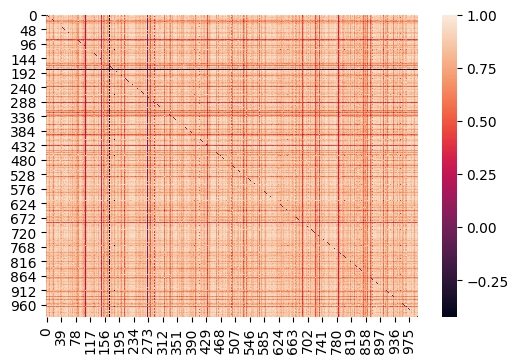

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(dpi=100)
sns.heatmap(sim_mat)

## 3.2 PageRank score

In [0]:
#applico l'algoritmo di pagerank per calcolare nel grafo i documenti più importanti
import networkx as nx
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(reviews)), reverse=True)

# genero sn review (in poche parole mi ritornano le review più importanti per ogni categoria)
sn = 5
best_reviews = []
for i in range(sn):
  tmp = bdata.loc[bdata["reviewTextLemmatized"]==ranked_sentences[i][1]]["reviewText"].tolist()
  print(" ".join(tmp).replace("\n",""),"\n")
  best_reviews.append(" ".join(tmp))

I love my xbox. I have been fortunate to avoid any of the issues that others have had in terms of the Bluray drive among others. I think people need to have patience when it comes to new systems such as the Xbox One and PS4. You cannot compare a system in its first months to a system that has eight years of work into it. Don't worry folks, it'll get there. I recommend this to those who are willing to put up with some rough edges. I don't regret buying the system but I must admit that I am a microsoft person (windows 8, windows phone). If you are turned off by M$ then you might want to reevaluate your purchase.Xbox live plays smooth. I am confident that they will fix the party system (again, a launch issue). Soon we'll forget it ever sucked. The chat quality is much improved.The controller feels right. It was a seamless transition for me. I can't tell where it is different but I can tell it just feels right.Kinect. This is a polarizing bugger. I like it. I don't use the remote anymore f

## OVERVIEW

In [0]:
#magari fare un wordcloud dove andiamo a mostrare le parole all'interno delle reviews più significative
!git clone https://github.com/amueller/word_cloud.git
!cd word_cloud
!pip install .

Cloning into 'word_cloud'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (378/378), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 4070 (delta 202), reused 317 (delta 163), pack-reused 3692
Receiving objects: 100% (4070/4070), 77.39 MiB | 39.21 MiB/s, done.
Resolving deltas: 100% (2258/2258), done.
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


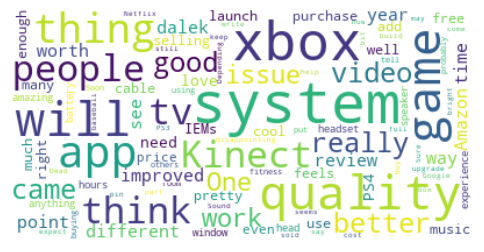

In [0]:
#si puo considerare di applicare una maschera
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

# Start with one review:
text = best_reviews
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(best_reviews))
# Display the generated image:
plt.figure(dpi=100)
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis("off")
wordcloud.to_file("drive/My Drive/images/TextMining/WordCloudBestReview.png")

# 4.0 CLUSTERING

In this section we'll go through clustering the bad reviews according to a problem that the reviews is about. 

To achieve this, first of all we manually label 20 reviews based on our insight, and we used them as centroids for our clustering problems.

In [0]:
#cambiare directory se non funziona questa
centroids = pd.read_csv("drive/My Drive/images/TextMining/reviews_to_centroid.csv",delimiter=";")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
text     60 non-null object
type     60 non-null object
fonte    60 non-null object
dtypes: object(3)
memory usage: 1.5+ KB


## 4.1 Preprocessing

In [0]:
#preprocessing
centroids["reviewTextNormalized"] = centroids.apply(lambda row:getNormalized(row["text"]),axis=1)
with contextlib.redirect_stdout(None):
    centroids["reviewTextNormalized"] = [' '.join([spell(i) for i in x.split()]) for x in centroids['reviewTextNormalized']]
centroids["reviewTextStopwords"] = centroids.apply(lambda x:getStopWords(x["reviewTextNormalized"]),axis=1)
centroids["reviewTextWordnetEnglish"] = centroids.apply(lambda row:getWordEnglish(row["reviewTextStopwords"]),axis=1)
centroids["reviewTextLemmatized"] = centroids.apply(lambda row:getLemmatized(row["reviewTextWordnetEnglish"]),axis=1)
centroids = centroids.loc[pd.isna(centroids["reviewTextLemmatized"])==False]
centroids.to_csv("drive/My Drive/images/TextMining/centroidsAfterAllPreprocessing.csv")

## 4.2 PageRank score for n best reviews

In this section we'll use the PageRank algorithm to select the most important reviews, based on they're similarity.

In [0]:
import pandas as pd
bdata = pd.read_csv("drive/My Drive/images/TextMining/datasetAfterAllPreprocessing.csv")
sdata = pd.read_csv("drive/My Drive/images/TextMining/centroidsAfterAllPreprocessing.csv")

In [0]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

def getPageRank(reviews,n=100):
  sentence_vectors = []
  #si calcola per ogni review la media dell'embeddings di ogni coefficente
  for i in reviews: 
    if len(i) != 0:
      v = sum([words_embeddings.get(w,np.zeros(100,)) for w in nltk.word_tokenize(i)])/(len(nltk.word_tokenize(i))+0.001)
    else:
      v = np.zeros((100,))
    sentence_vectors.append(v)

  #calcolo per ogni review la similarità tra i vettori di embeddings
  sim_mat = np.zeros([len(reviews),len(reviews)])
  for i in range(len(reviews)):
    for j in range(len(reviews)):
      if i != j:
        sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

  #applico l'algoritmo di pagerank per calcolare nel grafo i documenti più importanti
  nx_graph = nx.from_numpy_array(sim_mat)
  scores = nx.pagerank(nx_graph)
  ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(reviews)), reverse=True)
  print(len(ranked_sentences))
  best_reviews = [ranked_sentences[k][1] for k in range(0,n)]
  return best_reviews,sentence_vectors

In [0]:
#prendo le top review negative
reviews = bdata.loc[pd.isna(bdata["reviewTextLemmatized"])==False].loc[bdata["overall"]==1]["reviewTextLemmatized"].tolist()
reviews = reviews[:500] 
reviews_text,reviews_sentences = getPageRank(reviews)

500


## 4.3 Vocabolary check

In this section we'll uniform the vocaboulary, because it might be that the hand labeled reviews will have words that arent in the vocaboulary of the reviews (because we added ones outside the dataset). In that case, we'll add the new words to the vocaboulary.

In [0]:
#check necessario: vedere se centroidi e reviews hanno lo stesso vocabolario, senno bisogna unirlo
vocab_centroids = list(set(nltk.word_tokenize(" ".join(centroids_text))))
vocab_reviews = list(set(nltk.word_tokenize(" ".join(reviews_text))))
print("Lunghezza vocabolario centroidi:",len(vocab_centroids))
print("Lunghezza vocabolario reviews",len(vocab_reviews))
tmp = []
for word in vocab_centroids:
  if word in vocab_reviews:
    pass
  else:
    tmp.append(word)
print("Parole in centroids ma non in reviews:",len(tmp))
#uniamo, anche se mi sembra strano
vocab_reviews.extend(tmp)
vocab_tot = vocab_reviews
print("Vocabolario totale:",len(vocab_tot))

Lunghezza vocabolario centroidi: 360
Lunghezza vocabolario reviews 2221
Parole in centroids ma non in reviews: 59
Vocabolario totale: 2280


## 4.4 Get centroids and clusters

In [0]:
#VECTORIZE on centroids
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

centroidi = []
for i in set(sdata["type"]):
  print(i)
  vectorizer = TfidfVectorizer(use_idf=False,smooth_idf=False,sublinear_tf=True, norm='l2',vocabulary=vocab_tot)
  centroids_text = sdata.loc[sdata["type"]==i]["reviewTextLemmatized"]
  vect = vectorizer.fit_transform(centroids_text)

  knn = MiniBatchKMeans(n_clusters=1) #3
  centroids_label = sdata.loc[sdata["type"]==i]["type"]
  knn.fit(vect,) #centroids_label
  centroidi.append(knn.cluster_centers_)
  
print("Numero centroidi trovati:",len(centroidi))

compatibility issue
quality issue
durability issue
Numero centroidi trovati: 3


In [0]:
#VECTORIZE on data

#vectorizer
vectorizer = TfidfVectorizer(use_idf=False,smooth_idf=False,sublinear_tf=True, norm='l2',vocabulary=vocab_tot)

#aggiugno questa frase per poi poterla plottare
phrase_to_plot = "my computer broke after buy steal"
reviews_text.append(phrase_to_plot)
vect0 = vectorizer.fit_transform(reviews_text).toarray()
len(vect0)

101

In [0]:
#pca for tutto #RIVEDERLA PERCHè NON MI CONVINCE PIU DI TANTO
pca = PCA(n_components=2, random_state=420)
print(len(vect0))
vect0 = list(vect0)
for i in centroidi:
  vect0.extend(i)
vect0 = np.array(vect0)
print(len(vect0))
#quindi abbiamo [review_texts][phrase][centroids]
reduced_ = pca.fit_transform(vect0)
reduced_features = reduced_[:-4]
reduced_phrase = reduced_[-4:-3]
reduced_centroids = reduced_[-3:]

101
104


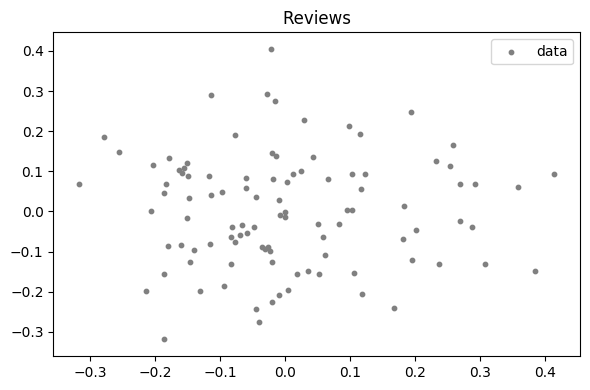

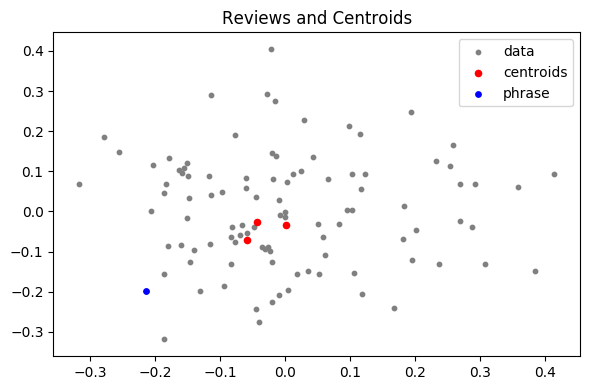

In [0]:
#plotting the data
plt.figure(dpi=100)
plt.title("Reviews")
plt.scatter(reduced_features[:,0], reduced_features[:,1], s=10,c="gray",label="data"); 
plt.legend(bbox_to_anchor=(1.,1.));
plt.tight_layout()
plt.savefig("drive/My Drive/images/TextMining/CLUSTER IMAGES/0_onlyreviews.png")

plt.figure(dpi=100)
plt.title("Reviews and Centroids")
plt.scatter(reduced_features[:,0], reduced_features[:,1], s=10,c="gray",label="data"); 
plt.scatter(reduced_centroids[:,0], reduced_centroids[:,1], s=20,c="red",label="centroids"); 
plt.scatter(reduced_phrase[:,0], reduced_phrase[:,1], s=15,c="blue",label="phrase"); 
plt.legend(bbox_to_anchor=(1.,1.));
plt.tight_layout()
plt.savefig("drive/My Drive/images/TextMining/CLUSTER IMAGES/1_centroids&reviews.png")

In [0]:
reduced_features = list(reduced_features)
reduced_features.extend(reduced_phrase)
reduced_features = np.array(reduced_features)
len(reduced_features)

101

In [0]:
#CLUSTERING WITH FIXED CENTROIDS
#CHECK THE DISTANCE FOR EACH POINT TO THE NEAREST CENTROIDS
from sklearn.metrics.pairwise import euclidean_distances
points = reduced_features
centroids = reduced_centroids
out = []
for point in points:
  xx = 0.2
  c = 4
  for center in centroids:
    cs = euclidean_distances([point],[center])
    if (cs < xx):
      xx = cs
      c = list([list(x) for x in centroids]).index(list(center)) #capire cosa mi restituisce sta roba perche mi da una matrice e non un numero singolo
  out.append([point[0],point[1],float(xx),c])  #magari provare con list(centroids) ma non funziona strano

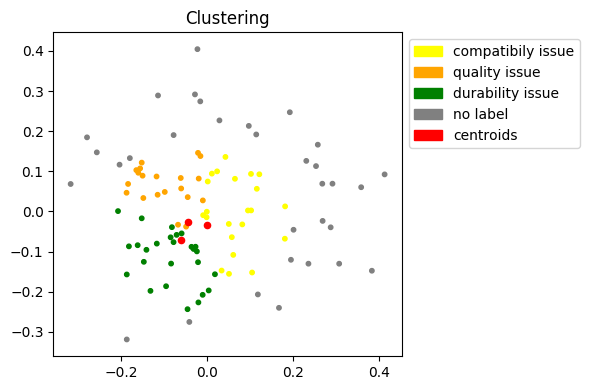

In [0]:
from matplotlib.patches import Patch
#plotting the data
plt.figure(dpi=100)
plt.title("Clustering")
reduced_cluster_data = np.array(out)
reduced_centroids = np.array(centroids)
colors = {0:'yellow', 1:'orange', 2:'green',4:'gray'}

plt.scatter(reduced_cluster_data[:,0][:-1], reduced_cluster_data[:,1][:-1],s=10, c=pd.Series(reduced_cluster_data[:,3][:-1]).apply(lambda x:colors[x])); 
plt.scatter(reduced_centroids[:,0], reduced_centroids[:,1], c="red",s=20); 
#plt.scatter(reduced_cluster_data[:,0][-1:],reduced_cluster_data[:,1][-1:],s=15,c="blue")
legend_ = [Patch(facecolor='yellow', edgecolor='yellow', label='compatibily issue'), 
           Patch(facecolor='orange', edgecolor='orange', label='quality issue'),
           Patch(facecolor='green', edgecolor='green', label='durability issue'),
           Patch(facecolor='gray', edgecolor='gray', label='no label'),
           Patch(facecolor='red', edgecolor='red', label='centroids'),]
plt.legend(handles=legend_,bbox_to_anchor=(1.,1.));
plt.tight_layout()
plt.savefig("drive/My Drive/images/TextMining/CLUSTER IMAGES/2_cluster.png")

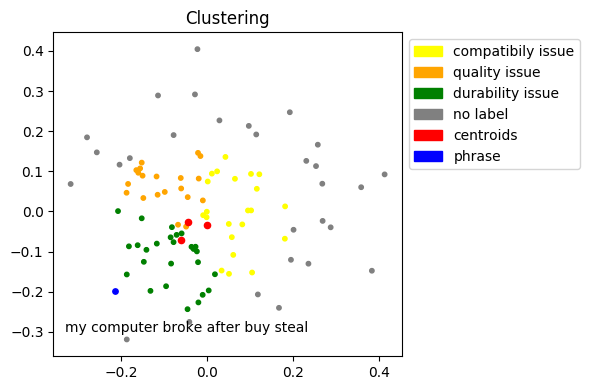

In [0]:
#plotting the data ANNOTATED
plt.figure(dpi=100)
plt.title("Clustering")
reduced_cluster_data = np.array(out)
reduced_centroids = np.array(centroids)
colors = {0:'yellow', 1:'orange', 2:'green',4:'gray'}

plt.scatter(reduced_cluster_data[:,0][:-4], reduced_cluster_data[:,1][:-4],s=10, c=pd.Series(reduced_cluster_data[:,3][:-4]).apply(lambda x:colors[x])); 
plt.scatter(reduced_centroids[:,0], reduced_centroids[:,1], c="red",s=20); 
plt.annotate(phrase_to_plot,xy=(-0.33,-0.3),size=10) #bo da rivedere credo il posizionamento, senno si puo plottare fuori
plt.scatter(reduced_cluster_data[:,0][-1:],reduced_cluster_data[:,1][-1:],s=15,c="blue")

legend_ = [Patch(facecolor='yellow', edgecolor='yellow', label='compatibily issue'), 
           Patch(facecolor='orange', edgecolor='orange', label='quality issue'),
           Patch(facecolor='green', edgecolor='green', label='durability issue'),
           Patch(facecolor='gray', edgecolor='gray', label='no label'),
          Patch(facecolor='red', edgecolor='red', label='centroids'),
           Patch(facecolor='blue', edgecolor='blue', label="phrase"),]
plt.legend(handles=legend_,bbox_to_anchor=(1.,1.));

plt.tight_layout()
plt.savefig("drive/My Drive/images/TextMining/CLUSTER IMAGES/3_clusterAnnotated.png")

# **5.0 CONCLUSIONS**

**Can we classify an object according to its review ?**

We did the classification with two methods: one using only tf-idf rapresentation and another one using Doc2Vec for word embeddings. 
In both cases the max accuracy was near 50%.



**Are there more important reviews in the dataset?**

Using PageRank we computed the most important reviews in the dataset: they are referred to ... .


**Is there a way to cluster reviews based on what did go wrong?**

Our implementation taken into account hand labeled review that specifies a certain type of problem (compatibily problem, AGGIUNGERE LE VARIE CLASSI) and from that we extract the centroids, then we classified unknown reviews based on distance between them and the centroids. 
This methods leads us to discover a good way to classify reviews based on pre defined labels; reviews that doesn not fall in a particular problem will be rejected to an unknown class.